Justin Dano <br>
FE550 - Data Visualization Applications<br>
Assignment #2<br>
Due 9/27/2017<br>

#  Cryptocurrency Arbitrage - Frequency and Duration Analysis 

## 1. Introduction

The aim of this topic is to determine if trading cryptocurrencies can be incorporated into a profitable investment strategy. There are several key factors that provide motivation for analyzing the cryptocurrency market. The first lies in its novelty. As Scott Patterson emphasizes in his book [Dark Pools](https://www.amazon.com/dp/B006OFHLG6/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1), history has shown time and again that those first to capitalize on novel technologies are often rewarded. This leads to the next factor, which  can be characterized as "dumb money". Cryptocurrency markets are susceptible to wild price swings, combine that with universal access and low barrier of entry and you have a market full of uninformed trades relying solely on market sentiment. This can provide statistical algorithms more possibilities for finding inefficiencies and making profitable trades compared to traditional markets. The final factor is the transparency of the market. Blockchain technology provides the ledger for all to see. This visibility greatly reduces the effort and cost needed for data retrieval. Similar data from Equity exchanges are almost unattainable for a retail trader, with some subscriptions costing thousands of dollars in monthly fees.<sup>(1)</sup> 

In previous work, arbitrage opportunities were shown to indeed exist. The next logical step in designing a trading strategy is to achieve an intuition about the domain of such opportunities. More specifically, the analysis presented in this workbook aims to answer the following questions:

<b> 1. How often are arbitrage opportunities created? </b><br>
<b> 2. Have these opportunities increased or decreased over time? </b><br>
<b> 3. How long do arbitrage opportunities typically last? </b>


As was done in the previous assignment, the data will be pulled from different exchanges and sampled to the minute-tick resolution. Next the duration and frequency for each arbitrage opportunity will be calculated. After the calculations are performed, visualizations will be used to identify the number of arbitrage opportunities. Next the analysis will look at the duration of each arbitrage and plot the frequency distribution to gain an understanding of how long these opportunities last.

#### Technology Stack
Python 3.6.1 <br>
Anaconda 3-4.4.0 <br>
Pandas 0.20.3 <br>
Matplotlib 2.0.2 <br>
Developed on a Jupyter notebook.

## 2. Data Retrieval

The data used for this analysis is from the Bitcoin blockchain provided by [Bitcoincharts](https://bitcoincharts.com/about/markets-api/). Bitcoincharts offers free transaction data from several exchanges. The exchanges used in this analysis are:
+ [Bitstamp](https://www.bitstamp.net/) 
+ [GDAX (Coinbase)](https://www.gdax.com/)
+ [Kraken](https://www.kraken.com/)

The data, which is a list of completed transactions, can be downloaded as a .csv file. The fields include a Unix timestamp, the price paid, and the amount of Bitcoin that was purchased. After downloading the data, each exchange was split into 53750k-byte files. Enough files were taken from each exchange to cover all trading since the beginning of 2016.

In [336]:
# Import Modules and settings for styling
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.mpl_style', 'default')
plt.rcParams['font.family'] = 'serif'

#### To test locally, please update the path variable to the directory where the csv data has been saved. The directory should include three folders, "bitstamp", "kraken", and "coinbase" with their corresponding csv data in each file.

In [338]:
def read_data(exchange):
    """
    Read .csv data covering trades since at least 2016 for each exchange
    :param exchange: String
    :return: Dataframe
    """
    path = r'/home/justin/PycharmProjects/bitcoin_arbitrage/' + exchange + '_2016'
    all_files = glob.glob(os.path.join(path, "*.csv"))
    csv_df = pd.DataFrame(columns=('timestamp', 'price', 'amount'))

    # Read in each CSV file for a given exchange
    for file in all_files:
        df = pd.read_csv(file, names=['timestamp', 'price', 'amount'], skiprows=1)

        # Manually drop last row, as read_csv does not support it with c-engine
        df.drop(df.index[len(df) - 1])
        csv_df = csv_df.append(df)

    # Convert Unix Timestamp to Date format (e.g. 1495803874 -> 2017-05-26 13:04:34)
    csv_df['timestamp'] = pd.to_datetime(csv_df['timestamp'], unit='s')
    csv_df = csv_df.sort_values(by='timestamp')

    # Remove nan values
    csv_df = csv_df.dropna()
    return csv_df.set_index('timestamp')

bitstamp_df = read_data('bitstamp')
kraken_df = read_data('kraken')
coinbase_df = read_data('coinbase')

In [339]:
bitstamp_df.head()

,price,amount
timestamp,,
2015-09-07 19:27:45,239.90,0.094418
2015-09-07 19:27:45,239.88,0.095793
2015-09-07 19:27:45,239.80,1.890000
2015-09-07 19:27:46,239.63,0.272300
2015-09-07 19:27:46,239.62,1.423728


## 3. Data Cleaning

The first step in the data cleaning process is resampling the data to the minute-tick resolution. The following step includes determining the time-frame for analysis. Given that the Kraken exchange had relatively low volume up until this recent year, the focus on this analysis will be trades from January 2017 to mid July 2017, covering a little more than 6 months.

In [340]:
def clean_data(df):
    """
    Resample data to the minute-tick level. Also take subset so to only look
    at trades for the year 2017
    :param df: dirty dataframe to be cleaned
    :return: cleaned dataframe 
    """
    sampled_df = pd.DataFrame()
    sampled_df['price'] = df.price.resample('60S').mean()
    sampled_df = sampled_df[(sampled_df.index >= '2017-01-01 00:00')]
    return sampled_df

bitstamp_df = clean_data(bitstamp_df)
kraken_df = clean_data(kraken_df)
coinbase_df = clean_data(coinbase_df)

In [341]:
bitstamp_df.tail()

,price
timestamp,
2017-07-17 22:19:00,2176.745000
2017-07-17 22:20:00,2175.450000
2017-07-17 22:21:00,2176.952000
2017-07-17 22:22:00,2175.503333
2017-07-17 22:23:00,2175.561500


## 4. Data Calculations and Transformation

As in the previous assignment, the spread is taken for two crosses:
    1. Kraken and Bitstamp
    2. Coinbase and Bitstamp
    
The spread is calculated by taking the absolute difference between price for each minute. 

In [343]:
def calculate_spread(exchange1, exchange2, spread_name, ex1_col, ex2_col):
    """
    Calculate spreads for two exchanges
    :param exchange1: dataframe of first exchange
    :param exchange2: dataframe of second exchange
    :param spread_name: string to name column of spread
    :param ex1_col: string to name first exchange column price
    :param ex2_col: string to name second exchange column price
    :return: dataframe with spreads
    """
    spread_df = pd.DataFrame(index=exchange2.index, columns=[ex1_col, ex2_col, spread_name])
    spread_df[ex1_col] = exchange1['price']
    spread_df[ex2_col] = exchange2['price']
    spread_df[spread_name] = (spread_df[ex1_col] - spread_df[ex2_col]).abs()

    return spread_df

kb_df = calculate_spread(kraken_df, bitstamp_df,  'kb_spread', 'k', 'b')
cb_df = calculate_spread(coinbase_df, bitstamp_df, 'cb_spread', 'c', 'b')

In [344]:
cb_df.tail()

,c,b,cb_spread
timestamp,,,
2017-07-17 22:19:00,2177.120000,2176.745000,0.375000
2017-07-17 22:20:00,2175.497600,2175.450000,0.047600
2017-07-17 22:21:00,2174.706667,2176.952000,2.245333
2017-07-17 22:22:00,2174.904000,2175.503333,0.599333
2017-07-17 22:23:00,2175.120781,2175.561500,0.440719


Since the goal of this analysis is to determine the frequency and duration of arbitrage opportunities, a feature, <b>arbitrage_duration</b> will be created to keep a running count for each arbitrage opportunity. Every minute the spread between two exchanges remain greater than or equal to $10, the count will increment by 1. This will indicate how many minutes in the time series the arbitrage opportunity has existed. Since the dataframe only contains samples with arbitrage opportunities, the index will contain sequences of minute data with intermittent breaks in time. For each break, the count will reset.

In [346]:
def calculate_arbitrage_duration(df, spread_col_name):
    """
    First takes subset of dataframe with rows that are considered an arbitrage opportunity.
    Next take cumulative sum of each consecutive row to determine the duration of each opportunity.
    :param df: Dataframe with the spread calculated between two exchanges
    :param spread_col_name: The name of the column in [df] that contains the spread
    :return: dataframe with duration count for each arbitrage opportunity
    """
    # Find rows that are arbitrage opportunities. The assumption has been at least $10 USD
    arbitrage_df = df.loc[df[spread_col_name] >= 10]
    
    # Create temporary timestamp column since diff() function does not work on index
    arbitrage_df['timestamp'] = arbitrage_df.index

    # Determine which rows have consecutive timestamps
    bool_delta = (arbitrage_df.timestamp.diff() == pd.Timedelta('1 minute'))
    
    # Drop timestamp column now, as its no longer needed
    del arbitrage_df['timestamp']
    
    # Get cumulative sum for consecutive rows
    delta_count = bool_delta.cumsum()
    
    # Resets cumulative sum each time non-consecutive row appears
    arbitrage_df['arbitrage_duration'] = bool_delta.mul(delta_count)\
        .diff().where(lambda x: x < 0)\
        .ffill().add(delta_count, fill_value=0) + 1
    
    return arbitrage_df

cb_arbitrage = calculate_arbitrage_duration(cb_df, 'cb_spread')
kb_arbitrage = calculate_arbitrage_duration(kb_df, 'kb_spread')

In [347]:
cb_arbitrage.head()

,c,b,cb_spread,arbitrage_duration
timestamp,,,,
2017-01-01 22:05:00,992.316389,1002.816667,10.500278,1.0
2017-01-01 22:06:00,991.908571,1003.180000,11.271429,2.0
2017-01-01 22:08:00,991.468000,1003.036250,11.568250,1.0
2017-01-01 22:10:00,992.136389,1002.810000,10.673611,1.0
2017-01-01 22:11:00,992.522258,1002.810000,10.287742,2.0


## 5. Data Analysis - Arbitrage Frequency 

Now that the duration for each opportunity has been calculated, the frequency of arbitrage opportunities can be plotted. First, a bar graph will be created to look at the number of arbitrage opportunities created each month.

In [348]:
# Plot distribution of opportunities across months
cb_sample_by_months = cb_arbitrage.loc[cb_arbitrage['arbitrage_duration'] == 1]
kb_sample_by_months = kb_arbitrage.loc[kb_arbitrage['arbitrage_duration'] == 1]

# Renaming titles for clarity
cb_sample_by_months= cb_sample_by_months.rename(columns={'arbitrage_duration': 'arbitrage_opportunities'})
kb_sample_by_months= kb_sample_by_months.rename(columns={'arbitrage_duration': 'arbitrage_opportunities'})

# Resamples data by Month
cb_sample_by_months = cb_sample_by_months.resample('M').count()
kb_sample_by_months = kb_sample_by_months.resample('M').count()

In [349]:
cb_sample_by_months

,c,b,cb_spread,arbitrage_opportunities
timestamp,,,,
2017-01-31,1007,1007,1007,1007
2017-02-28,440,440,440,440
2017-03-31,1411,1411,1411,1411
2017-04-30,2113,2113,2113,2113
2017-05-31,2353,2353,2353,2353
2017-06-30,2185,2185,2185,2185
2017-07-31,1272,1272,1272,1272


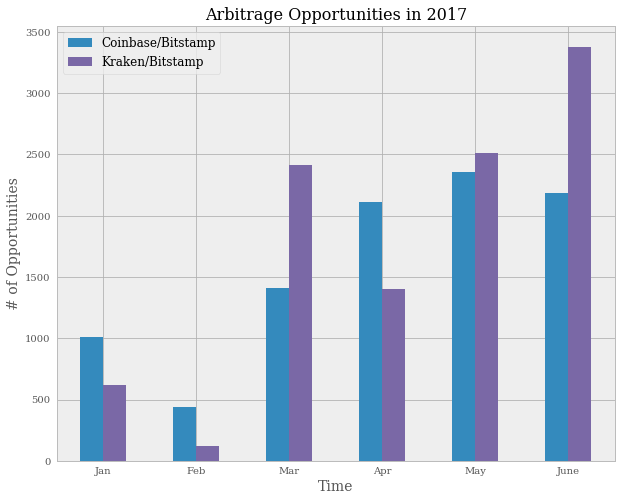

In [350]:
# Plotting number of opportunities by month (Bar Chart)
plot_df = pd.DataFrame(index=cb_sample_by_months.index)
plot_df['Coinbase/Bitstamp'] = cb_sample_by_months['arbitrage_opportunities']
plot_df['Kraken/Bitstamp'] = kb_sample_by_months['arbitrage_opportunities']

# Drop July as it was incomplete at time of data extraction
plot_df = plot_df[:-1]

#Plot Data
ax = plot_df.plot(kind='bar', figsize=(10,8))

# Format Visualization
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June'], rotation=0)
ax.legend(prop={'size': 12})
ax.set_title('Arbitrage Opportunities in 2017', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('# of Opportunities', fontsize=14);

From this graph it can be seen that a lot of opportunities for Bitcoin arbitrage do indeed exist between these two crosses. There also appears to be an upwards trend, which implies opportunities for arbitrage are becoming more prevalent compared to earlier in the year. The next visualization will look at the same distribution, but over the course of days instead of months.  

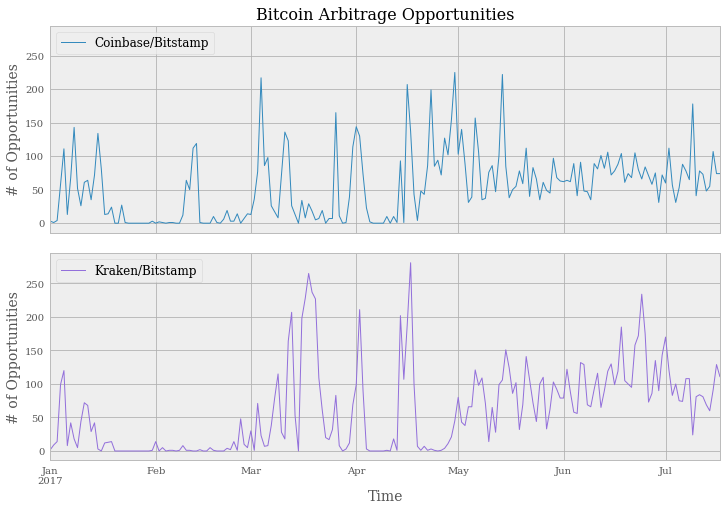

In [358]:
# Sample by days
cb_sample_by_days = cb_arbitrage.loc[cb_arbitrage['arbitrage_duration'] == 1]
cb_sample_by_days = cb_sample_by_days.resample('D').count()
kb_sample_by_days = kb_arbitrage.loc[kb_arbitrage['arbitrage_duration'] == 1]
kb_sample_by_days = kb_sample_by_days.resample('D').count()

# Create two subplots (one for each cross)
f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(12,8))

# Plot Data
ax = cb_sample_by_days['arbitrage_duration'].plot(ax=axarr[0], label='Coinbase/Bitstamp')
kb_sample_by_days['arbitrage_duration'].plot(ax=axarr[1], color='mediumpurple', label='Kraken/Bitstamp')

# Format Visualization
ax.set_title('Bitcoin Arbitrage Opportunities', fontsize=16)
ax.set_ylabel('# of Opportunities', fontsize=14)
axarr[1].set_ylabel('# of Opportunities', fontsize=14)
axarr[1].set_xlabel('Time', fontsize=14)
axarr[0].legend(loc='upper left', fontsize=12)
axarr[1].legend(loc='upper left', fontsize=12)
f.subplots_adjust(hspace=.1);

While there are several days in the beginning of the year that provided no arbitrage opportunities, the line chart shows recent arbitrage opportunities have been occurring much more frequently. 

It might be worth noting that there are 1440 minutes in a day. Each arbitrage opportunity is counted after the price drops below the defined spread of 10 USD. So if at 12:01am the price difference is greater than or equal to 10, then at 12:02am, the spread dropped below 10, this signifies one opportunity. If the price spread increases to $10 or greater at 12:03am, then a new arbitrage opportunity has been created. So assuming that each opportunity only lasts one minute, then the maximum number of opportunities that can occur in a day is 739 opportunities (1440/2 - 1). This is a rather simplified assumption however, since arbitrage opportunities are not confined to last only one minute. Now lets analyze the duration of these opportunities.  


## 6. Data Analysis - Arbitrage Duration

Since the cumulative time for each arbitrage opportunity has already been calculated, the final step in determining the duration is collecting the rows prior to a reset. These rows will provide the final duration for each opportunity in the <b>arbitrage_duration</b> column. First visualization will group duration into a few buckets:

#### Buckets
  1-5 Minutes<br>
  5-10 Minutes<br>
  10-15 Minutes<br>
  15-20 Minutes<br>
  20-30 Minutes<br> 
  30-45 Minutes<br>
  45-60 Minutes


In [359]:
def extract_duration_df(df):
    reset_indicies = []
    
    # Get each tick data that resets to 1
    reset_rows = df.index[df['arbitrage_duration'] == 1]
    
    # Determine index in dataframe for each reset row
    for r in reset_rows:
        reset_indicies.append(df.index.get_loc(r))

    reset_indicies.pop(0)
    reset_indicies = np.asarray(reset_indicies)
    target_indicies = reset_indicies - 1
    
    # Return an that array shows the indexes in the dataframe that contain 
    # the total time for a specific arbitrage opportunity
    return df.iloc[target_indicies]
   
cb_duration_df = extract_duration_df(cb_arbitrage)   
kb_duration_df = extract_duration_df(kb_arbitrage)    


# First analysis to cover different groupings over one hour
cb_duration_df1 = cb_duration_df.copy()
kb_duration_df1 = kb_duration_df.copy()

cb_duration_df1['cb_duration_category'] = pd.cut(cb_duration_df['arbitrage_duration'], bins=[1, 5, 10, 15, 20, 30, 45, 60], include_lowest=True)
kb_duration_df1['kb_duration_category'] = pd.cut(kb_duration_df['arbitrage_duration'], bins=[1, 5, 10, 15, 20, 30, 45, 60], include_lowest=True)

In [368]:
kb_duration_df1.tail()

,k,b,kb_spread,arbitrage_duration,kb_duration_category
timestamp,,,,,
2017-07-17 19:58:00,2109.911479,2123.002857,13.091378,15.0,"(10.0, 15.0]"
2017-07-17 20:01:00,2112.689333,2124.403333,11.714000,2.0,"(0.999, 5.0]"
2017-07-17 20:12:00,2142.816750,2156.170652,13.353902,9.0,"(5.0, 10.0]"
2017-07-17 21:19:00,2174.000000,2190.962000,16.962000,2.0,"(0.999, 5.0]"
2017-07-17 21:48:00,2165.037188,2179.243148,14.205961,7.0,"(5.0, 10.0]"


Now let us combine both dataframes so we can compare the crosses.

In [361]:
# Combine indicies of both dataframes
combine_df = pd.concat([cb_duration_df1, kb_duration_df1])

# Only concerned with duration column for visualization
plot_df = pd.DataFrame()
plot_df['kb_duration'] = combine_df['kb_duration_category']
plot_df['cb_duration'] = combine_df['cb_duration_category']
plot_df = plot_df.sort_index()

plot_df.head()

,kb_duration,cb_duration
timestamp,,
2017-01-01 16:45:00,"(5.0, 10.0]",NaN
2017-01-01 17:30:00,"(0.999, 5.0]",NaN
2017-01-01 22:06:00,NaN,"(0.999, 5.0]"
2017-01-01 22:08:00,NaN,"(0.999, 5.0]"
2017-01-01 22:12:00,NaN,"(0.999, 5.0]"


Now that a combined dataframe of each arbitrage duration exists for both crosses, a visualization can be made. 

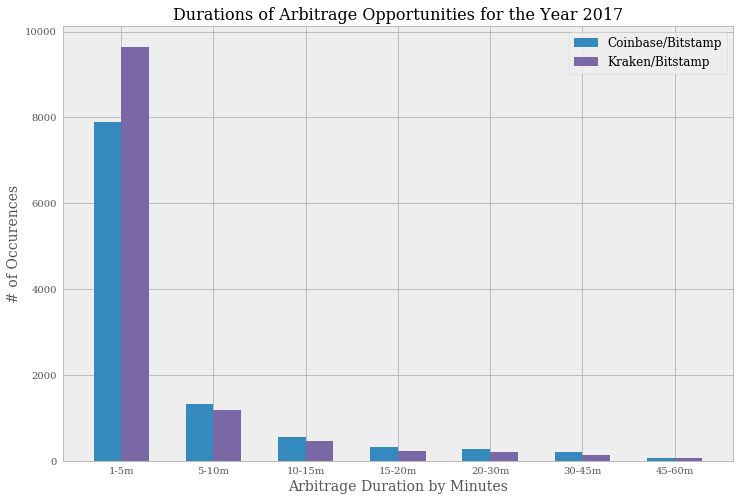

In [362]:
# Plot setup
width = 0.3
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# Plot Data
plot_df['cb_duration'].value_counts().plot(kind='bar', color='C0', ax=ax, width=width, position=1, align='center', label='Coinbase/Bitstamp')
plot_df['kb_duration'].value_counts().plot(kind='bar', color='C1', ax=ax, width=width, position=0, align='center', label='Kraken/Bitstamp')

# Format Visualization
labels = ['1-5m', '5-10m', '10-15m', '15-20m','20-30m', '30-45m', '45-60m']
ax.set_xticklabels(labels, rotation=0)
ax.set_title('Durations of Arbitrage Opportunities for the Year 2017', fontsize=16)
ax.set_xlabel('Arbitrage Duration by Minutes', fontsize=14)
ax.set_ylabel('# of Occurences', fontsize=14)
ax.legend(prop={'size': 12})
ax.autoscale();

As one may have guessed, the mass majority of opportunities only last between one and five minutes. It is interesting to note that some last a lot longer. Some arbitrage opportunities last for over an hour. One potential trading model could be made to potentially predict the longer duration arbitrage opportunities and trade based on that. Next, let us examine the the distribution of short opportunities that last up to 10 minutes.

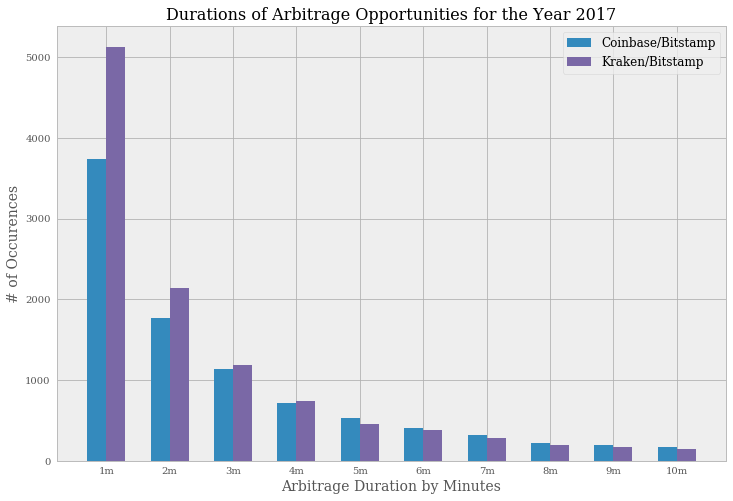

In [363]:
# Second duration analysis to cover different groupings over ten minutes
cb_duration_df2 = cb_duration_df.copy()
kb_duration_df2 = kb_duration_df.copy()

cb_duration_df2['cb_duration_category'] = pd.cut(cb_duration_df['arbitrage_duration'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], include_lowest=True)
kb_duration_df2['kb_duration_category'] = pd.cut(kb_duration_df['arbitrage_duration'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], include_lowest=True)

# Combine indicies of both dataframes
combine_df = pd.concat([cb_duration_df2, kb_duration_df2])

# Only concerned with duration column for visualization
plot_df = pd.DataFrame()
plot_df['kb_duration'] = combine_df['kb_duration_category']
plot_df['cb_duration'] = combine_df['cb_duration_category']
plot_df = plot_df.sort_index()

# Graph setup
width = 0.3
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# Plot Data
plot_df['cb_duration'].value_counts().plot(kind='bar', color='C0', ax=ax, width=width, position=1, align='center', label='Coinbase/Bitstamp')
plot_df['kb_duration'].value_counts().plot(kind='bar', color='C1', ax=ax, width=width, position=0, align='center', label='Kraken/Bitstamp')

# Format Visualization
labels = ['1m', '2m', '3m', '4m','5m', '6m', '7m', '8m', '9m', '10m']
ax.set_xticklabels(labels, rotation=0)
ax.legend()
ax.set_title('Durations of Arbitrage Opportunities for the Year 2017', fontsize=16)
ax.set_xlabel('Arbitrage Duration by Minutes', fontsize=14)
ax.set_ylabel('# of Occurences', fontsize=14)
ax.legend(prop={'size': 12})
ax.autoscale();

By looking at this graph, it appears that there still quite a few opportunities that last longer than a couple minutes. Further work will be needed to determine the actual duration needed to make both legs of an arbitrage trade. If we assume that both legs of an arbitrage trade can be completed within 5 minutes, there are still ample opportunities. The final analysis for this assignment will look at how the duration of opportunities has changed over time.

In [364]:
# Clean up the columns to avoid duplicates
cb_duration_df = cb_duration_df.rename(columns={"b": "cb", "arbitrage_duration": "cb_count"})
kb_duration_df = kb_duration_df.rename(columns={"b": "kb", "arbitrage_duration": "kb_count"})
plot_df = cb_duration_df
plot_df = pd.concat([cb_duration_df, kb_duration_df], axis=1)
plot_df.head()

,c,cb,cb_spread,cb_count,k,kb,kb_spread,kb_count
timestamp,,,,,,,,
2017-01-01 16:45:00,NaN,NaN,NaN,NaN,999.891,989.846579,10.044421,7.0
2017-01-01 17:30:00,NaN,NaN,NaN,NaN,996.002,985.334500,10.667500,1.0
2017-01-01 22:06:00,991.908571,1003.18000,11.271429,2.0,NaN,NaN,NaN,NaN
2017-01-01 22:08:00,991.468000,1003.03625,11.568250,1.0,NaN,NaN,NaN,NaN
2017-01-01 22:12:00,992.774211,1002.81000,10.035789,3.0,NaN,NaN,NaN,NaN


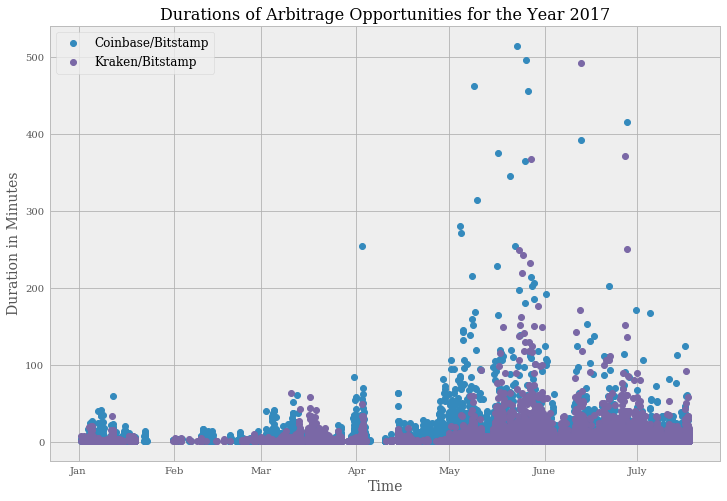

In [365]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# Plot Data
ax.plot(plot_df.index, plot_df.cb_count, "o", label='Coinbase/Bitstamp')
ax.plot(plot_df.index, plot_df.kb_count, "o", label='Kraken/Bitstamp')

# Format Visualization
ax.set_title('Durations of Arbitrage Opportunities for the Year 2017', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July'], rotation=0)
ax.set_ylabel('Duration in Minutes', fontsize=14)
ax.legend(prop={'size': 12}, loc='upper left');

The scatterplot above clearly shows a trend of longer arbitrage opportunities. Not only do the arbitrage opportunities increase in duration, but the number of outliers for very long opportunities appear to be increasing as well. Our final visualization will take a zoomed-in sample only considering opportunities shorter than 100 minutes.

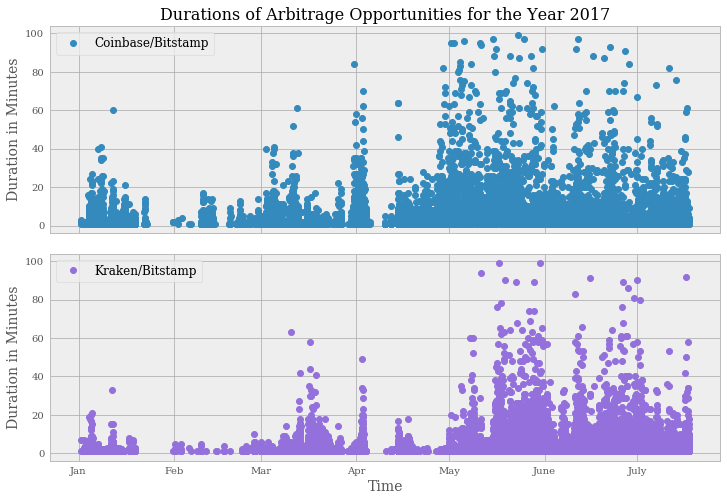

In [366]:
scatter_cb = plot_df[(plot_df['cb_count'] < 100 )]
scatter_kb = plot_df[(plot_df['kb_count'] < 100 )]

f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(12,8))

# Plot Data
axarr[0].plot(scatter_cb.index, scatter_cb.cb_count, 'o', label='Coinbase/Bitstamp')
axarr[1].plot(scatter_kb.index, scatter_kb.kb_count, "o", color='mediumpurple', label='Kraken/Bitstamp')

# Format Visualization
axarr[0].set_title('Durations of Arbitrage Opportunities for the Year 2017', fontsize=16)
axarr[1].set_xlabel('Time', fontsize=14)
axarr[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July'], rotation=0)
axarr[0].set_ylabel('Duration in Minutes', fontsize=14)
axarr[1].set_ylabel('Duration in Minutes', fontsize=14)
axarr[0].legend(loc='upper left', fontsize=12)
axarr[1].legend(loc='upper left', fontsize=12)
f.subplots_adjust(hspace=.1);

What is interesting about this final visualization is the ability to see just how many more opportunities exist for the Coinbase/Bitstamp cross compared to Kraken/Bitstamp. Also it is interesting to note that opportunities between both crosses seem to occur during the same time periods. For Example a spike can be seen at the beginning of April for both crosses. This makes sense though since Bitstamp is used for both crosses.

## 7. Conclusion

The analysis and visualizations have done a good job answering our research questions. It is clear now that there are hundreds of arbitrage opportunities created each month. Also the visualizations show an obvious trend of increased arbitrage opportunities over time. Finally, most arbitrage opportunities last only a few minutes, with the majority lasting only a minute. The visualization also showed how some  arbitrage opportunities can last for hours at a time. 

Future work can be done to look at how long it actually takes to complete both legs of an arbitrage trade. Once the estimated time to complete a real trade is done, a profitable trading strategy could possibly be created if real-life transactions can be completed within reasonable time.



References: <br>
    (1) https://nasdaqtrader.com/Trader.aspx?id=DPUSdata
    